# (25) Fit -- cuda (gaban)

**Motivation**: Fit on GABAN (one GPU). <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from model.train_vae import TrainerVAE, ConfigTrain
from model.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# from torch import _dynamo
# _dynamo.config.cache_size_limit = 1024

## Trainer

In [3]:
vae = VAE(ConfigVAE(
    n_kers=4,
    n_latent_scales=2, n_groups_per_scale=20, n_latent_per_group=7,
    scale_init=False, residual_kl=True, ada_groups=True,
))
tr = TrainerVAE(
    # model=torch.compile(vae),
    model=vae,
    cfg=ConfigTrain(
        lr=0.003, batch_size=512, epochs=2000, grad_clip=1000,
        lambda_anneal=True, lambda_init=1e-7, lambda_norm=1e-3,
        kl_beta=0.25, kl_anneal_cycles=1,
        scheduler_kws={'T_max': 660.0, 'eta_min': 1e-05}),
    device='cuda',
)
vae.cfg.total_latents()

210

In [4]:
vae.print()
vae.scales

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|     VAE     |  17.0 Mil  |
|     ---     |    ---     |
|     stem    |   1.1 K    |
|     pre     |   96.0 K   |
|  enc_tower  |  9.4 Mil   |
|     enc0    |   16.6 K   |
| enc_sampler |  1.4 Mil   |
| dec_sampler |  1.4 Mil   |
|    expand   |   71.0 K   |
|  dec_tower  |  4.5 Mil   |
|     post    |   40.0 K   |
|     out     |    578     |
+-------------+------------+

[8, 4]

In [5]:
len(vae.all_log_norm)

228

## Review train options

In [6]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

k-32_z-7x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)
ep2000-b512-lr(0.003)_beta(0.25)-anneal(1x0.3)_lambda(0.001)_grad(1000)

## Train

In [ ]:
comment = f"Clamp(4:None)+3xCosLR-NoCos_{tr.cfg.name()}"
tr.train(comment=comment)

epoch # 1615, avg loss: 12.744436:  81%|▊| 1615/2000 [29:19:52<6:59:32, 65.38s/i

## Update 21:56 pm

There was a bug in the dec sampler (ELU inplace thing). I removed that inplace. Hopefully this will make things better (logically, that inplace thing should NOT be there, so hopefully it will increase model performance and I can happily move on).


## Testing now:

- Probably the most benefit came from normalizing DeConv2D as well...?
- ENC0 should stabilize top latenst, less jumpy vals/gamma
- No clamp for mu and normalizing DeConv2D should stabilize training
- 3 x cos lr periods should find better local minimum

### TODO: after this training is done...

...test Arash vs. Hadi balancer, do they give the same answer?

## Debug Balancer

In [11]:
from model.utils_model import kl_balancer

In [8]:
x, norm = next(iter(tr.dl_tst))
with torch.no_grad():
    y, _, q, p = tr.model(x)
    kl_all, kl_diag = tr.model.loss_kl(q, p)

In [18]:
self = tr
gstep = 126000

In [19]:
balanced_kl, gamma, kl_vals = kl_balancer(
    kl_all=kl_all,
    alpha=self.alphas,
    coeff=self.betas[gstep],
    beta=self.cfg.kl_beta,
)

In [20]:
def kl_per_group(kl_all):
    kl_vals = torch.mean(kl_all, dim=0)
    kl_coeff_i = torch.abs(kl_all)
    kl_coeff_i = torch.mean(kl_coeff_i, dim=0, keepdim=True) + 0.01

    return kl_coeff_i, kl_vals


def kl_balancer_arash(kl_all, kl_coeff=1.0, kl_balance=False, alpha_i=None):
    if kl_balance and kl_coeff < 1.0:
        alpha_i = alpha_i.unsqueeze(0)

        kl_all = torch.stack(kl_all, dim=1)
        kl_coeff_i, kl_vals = kl_per_group(kl_all)

        kl_coeff_i = kl_coeff_i / alpha_i
        kl_coeff_i = kl_coeff_i / torch.mean(kl_coeff_i, dim=1, keepdim=True)
        kl = torch.sum(kl_all * kl_coeff_i.detach(), dim=1)

        # for reporting
        kl_coeffs = kl_coeff_i.squeeze(0)
    else:
        kl_all = torch.stack(kl_all, dim=1)
        kl_vals = torch.mean(kl_all, dim=0)
        kl = torch.sum(kl_all, dim=1)
        kl_coeffs = torch.ones(size=(len(kl_vals),))

    return kl_coeff * kl, kl_coeffs, kl_vals

In [21]:
balanced_kl_arash, gamma_arash, kl_vals_arash = kl_balancer_arash(
    kl_all=kl_all,
    alpha_i=self.alphas,
    kl_coeff=self.betas[gstep],
)

In [31]:
(balanced_kl - balanced_kl_arash).sum(), (kl_vals - kl_vals_arash).sum(), (gamma - gamma_arash).sum()

(tensor(0., device='cuda:0'), tensor(0., device='cuda:0'), tensor(0.))

### Observation: the KL balancer is correct

In [32]:
gamma = np.stack(tr.stats['gamma'])
gamma.shape

(125975, 30)

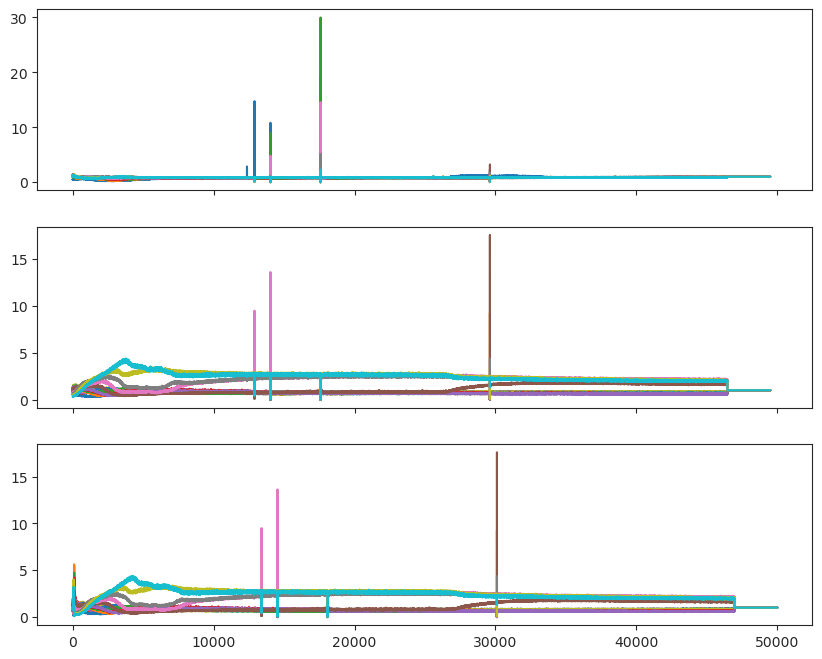

In [33]:
fig, axes = create_figure(3, 1, (10, 8), 'all')
axes[0].plot(gamma[500:50000, :10])
axes[1].plot(gamma[500:50000, 10:])
axes[2].plot(gamma[:50000, 10:])
plt.show()

In [34]:
100 * len(tr.stats['grad']) / tr.n_iters

0.18205128205128204

In [35]:
np.max(tr.stats['grad'])

6941653860352.0

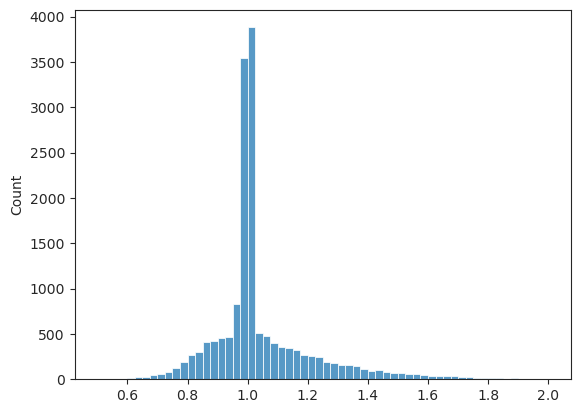

In [36]:
all_norm = [torch.exp(n.ravel()) for n in vae.all_log_norm]
all_norm = to_np(torch.cat(all_norm))
sns.histplot(all_norm, bins=np.linspace(0.5, 2, 61));

In [37]:
np.max(all_norm), 100 * (all_norm < 0.5).sum() / len(all_norm), 100 * (all_norm > 2).sum() / len(all_norm)

(6.2556257, 0.28823745860419475, 0.35569728934134676)

In [38]:
all_lognorm = to_np(torch.cat(vae.all_log_norm))

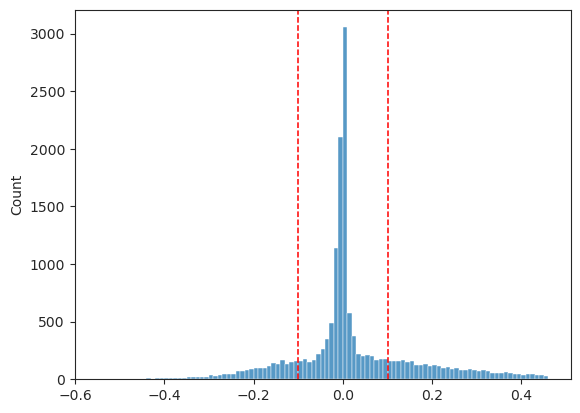

In [39]:
ax = sns.histplot(all_lognorm, bins=np.linspace(-0.5, 0.51, 102) - 0.05)
ax.axvline(0.1, ls='--', lw=1.1, color='r')
ax.axvline(-0.1, ls='--', lw=1.1, color='r')

In [40]:
from model.vae2d import *

In [43]:
norms = collections.defaultdict(list)
norms['stem'] = list(to_np(vae.stem.lognorm.exp()))

for cell in vae.enc_tower:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_enc"].extend(
                list(to_np(m.lognorm.exp())))

for cell in vae.dec_tower:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_dec"].extend(
                list(to_np(m.lognorm.exp())))

for cell in vae.enc_sampler:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms['enc_sampler'].extend(
                list(to_np(m.lognorm.exp())))

for cell in vae.dec_sampler:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms['dec_sampler'].extend(
                list(to_np(m.lognorm.exp())))

for cell in vae.expand:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms['expand'].extend(
                list(to_np(m.lognorm.exp())))

for cell in vae.pre:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_pre"].extend(
                list(to_np(m.lognorm.exp())))
            
for cell in vae.post:
    for m in cell.modules():
        if hasattr(m, 'lognorm'):
            norms[f"{type(cell).__name__}_post"].extend(
                list(to_np(m.lognorm.exp())))

norms = dict(sorted(norms.items()))

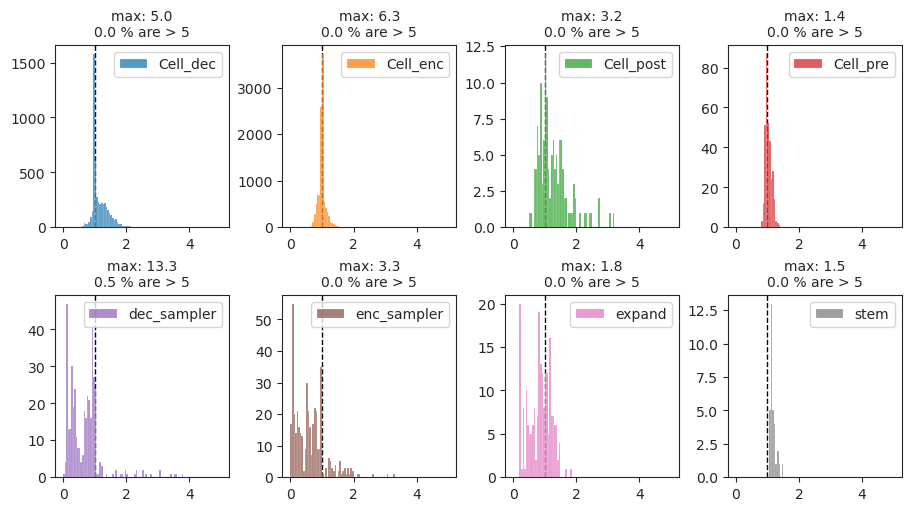

In [44]:
fig, axes = create_figure(2, 4, (9, 5), constrained_layout=True)
for i, (k, v) in enumerate(norms.items()):
    ax = axes.flat[i]
    ax.axvline(1, color='k', ls='--', lw=1.0, zorder=0)
    sns.histplot(v, color=f"C{i}", bins=np.linspace(0, 5, 101), label=k, ax=ax)
    title = f"max: {np.max(v):0.1f}\n{100 * (np.array(v) > 5).sum() / len(v):0.1f} % are > 5"
    ax.set_title(title, fontsize=10)
    ax.set_ylabel('')
    ax.legend()
plt.show()

In [45]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 3min 42s, sys: 2.17 s, total: 3min 44s
Wall time: 3min 34s


In [46]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(loss_summary)

{
    'kl': {'vae': 40.29, 'ema': 39.24},
    'epe': {'vae': 2.91, 'ema': 2.61},
    'l1': {'vae': 2.3, 'ema': 2.02},
    'l2': {'vae': 0.71, 'ema': 0.63}
}

fig/sample (VAE)

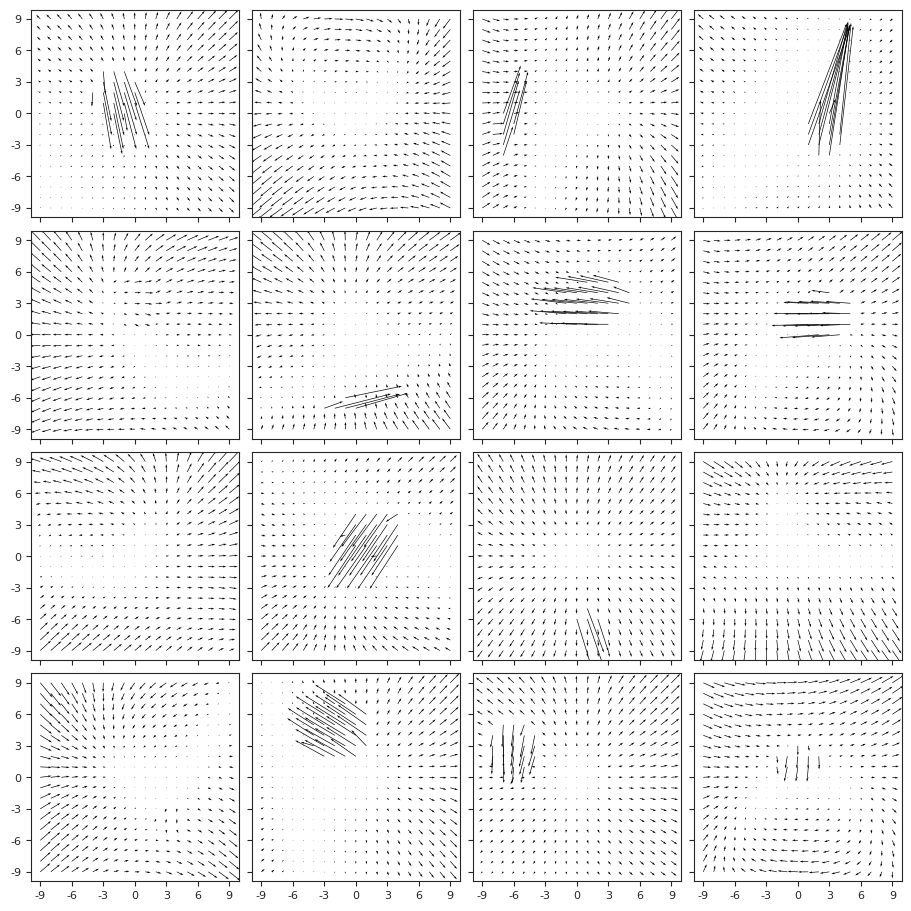

fig/sample (EMA)

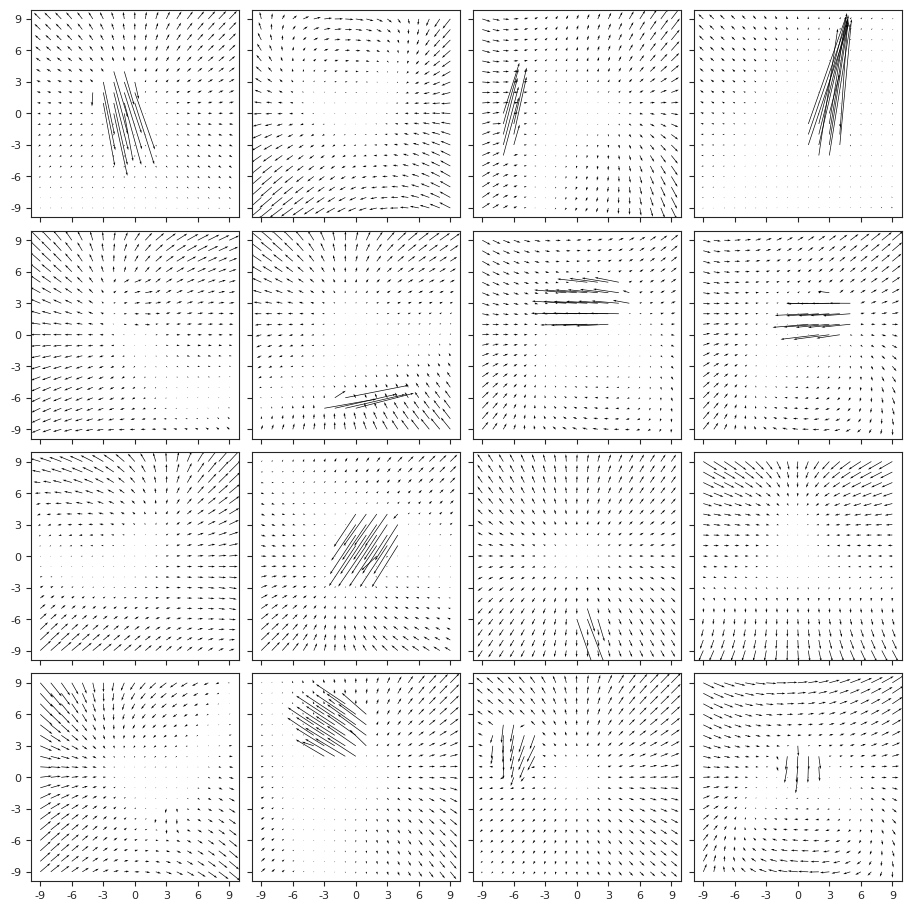

----------------------------------------------------------------------

fig/regression (VAE)

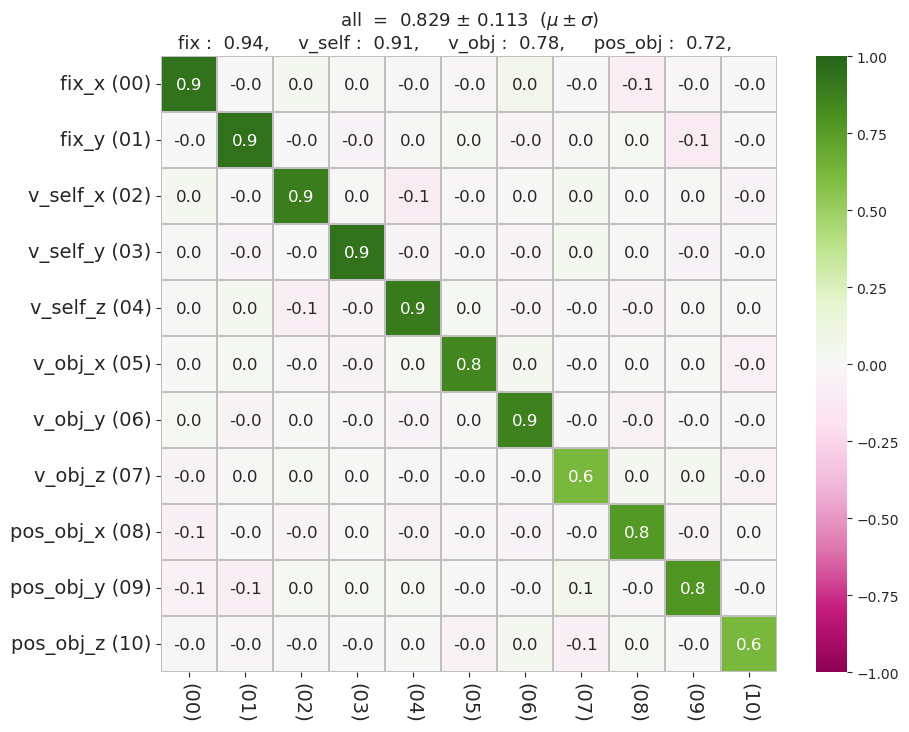

fig/regression (EMA)

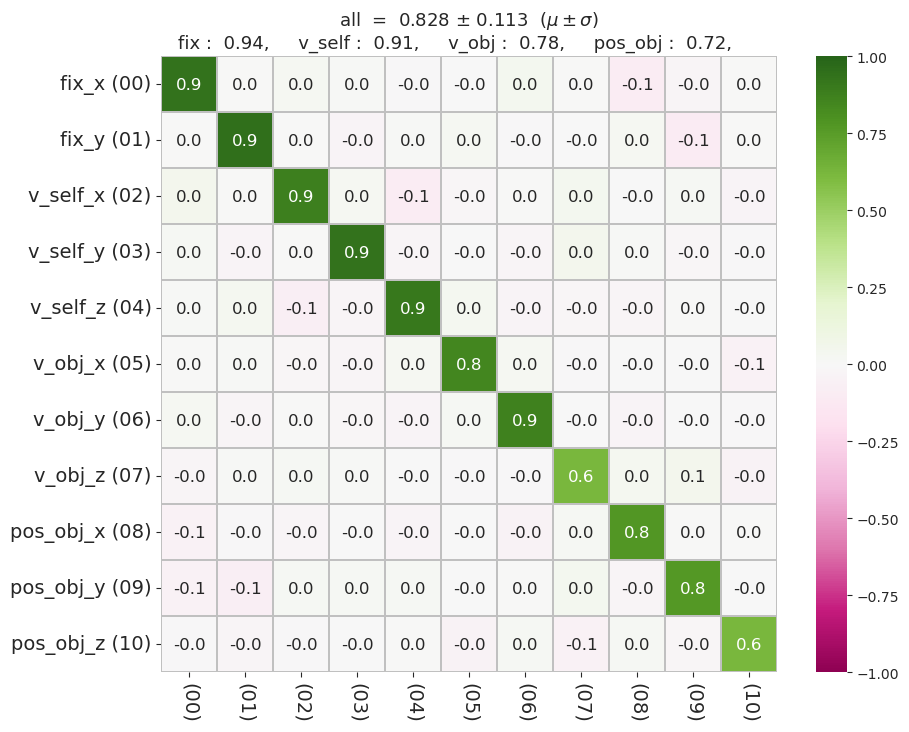

----------------------------------------------------------------------

fig/mutual_info (VAE)

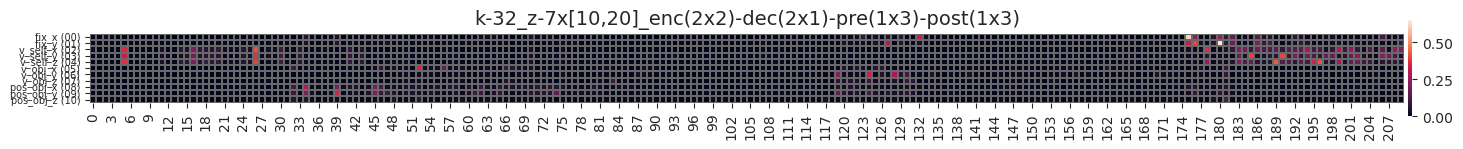

fig/mutual_info (EMA)

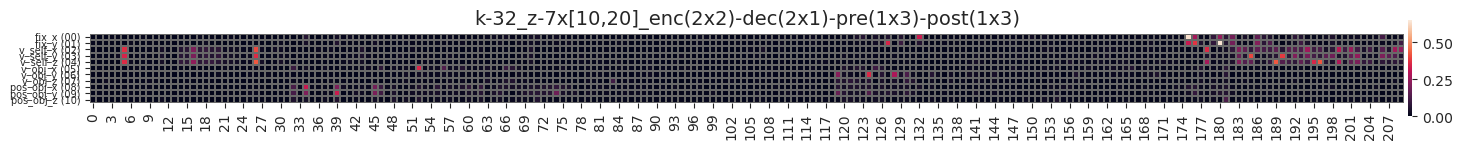

----------------------------------------------------------------------

In [47]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

## mi parallel is faster

In [48]:
list(val_ema)

['x_sample',
 'z_sample',
 'z_vld',
 'z_tst',
 'g_vld',
 'g_tst',
 'regr/mi',
 'regr/r',
 'regr/lr',
 'fig/sample',
 'fig/regression',
 'fig/mutual_info']

In [51]:
n_jobs = -1

from sklearn.feature_selection import mutual_info_regression

z = val_ema['z_vld'].copy()
g = val_ema['g_vld'].copy()

In [52]:
%%time

with joblib.parallel_backend('multiprocessing'):
    mi = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(mutual_info_regression)
        (z, g[:, i]) for i in range(g.shape[-1])
    )
mi = np.stack(mi)

CPU times: user 659 ms, sys: 4.05 s, total: 4.71 s
Wall time: 15.2 s


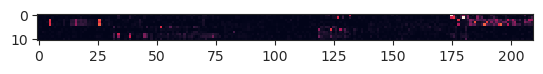

In [53]:
plt.imshow(mi)

In [54]:
%%time

with joblib.parallel_backend('multiprocessing'):
    mi = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(mutual_info_regression)
        (g, z[:, i]) for i in range(z.shape[-1])
    )
mi = np.stack(mi).T

CPU times: user 1.35 s, sys: 4.43 s, total: 5.77 s
Wall time: 9.83 s


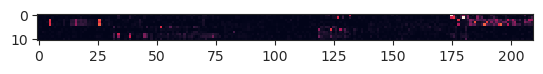

In [55]:
plt.imshow(mi)

In [56]:
%%time

mi = np.zeros((g.shape[-1], z.shape[-1]))
for i in range(len(mi)):
    mi[i] = mutual_info_regression(z, g[:, i])

CPU times: user 1min 13s, sys: 92.3 ms, total: 1min 13s
Wall time: 1min 13s


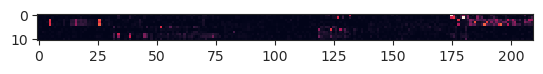

In [57]:
plt.imshow(mi)